# Imports

In [593]:
import numpy as np
import pickle
import os
import re
import pandas as pd
from tqdm import tqdm
import glob
import networkx as nx

import sys
sys.path.append("../../scripts") # TODO: make this part of pythonpath?

import matplotlib.pyplot as plt

from scripts.run_bubblewrap import BubblewrapRun

In [594]:
%matplotlib inline
all_inline = True

# Individual analysis

## Individial file discovery/loading

In [611]:
files = glob.glob("*pickle")
files.sort()
files[-5:]

['bubblewrap_run_2023-06-08-09-37-18.pickle',
 'bubblewrap_run_2023-06-08-09-47-36.pickle',
 'bubblewrap_run_2023-06-08-09-53-47.pickle',
 'bubblewrap_run_2023-06-08-11-47-52.pickle',
 'bubblewrap_run_2023-06-08-13-09-50.pickle']

In [639]:
file = 'bubblewrap_run_2023-06-08-11-47-52.pickle'
# file = files[-1]
file

'bubblewrap_run_2023-06-08-11-47-52.pickle'

In [640]:
with open(file, "rb") as fhan:
    br = pickle.load(fhan)
    if br.bw_parameters and "seed" not in br.bw_parameters:
        br.bw_parameters["seed"] = 42
        
for key, value in br.bw_parameters.items():
    print(f"{key}: {value}")
print(f"input file: {br.file}")
print(f"savefile: {br.outfile}")
print(f"# of dead nodes: {len(br.dead_nodes)}")
print(f"# of steps: {br.entropy_list.shape[0]}")

num: 200
lam: 0.001
nu: 0.001
eps: 0.001
step: 0.08
M: 30
B_thresh: -10
batch: False
batch_size: 1
go_fast: False
lookahead_steps: [1, 2, 3, 4, 5, 8, 10, 16, 32, 64, 128]
seed: 42
save_A: False
input file: ./generated/datasets/jpca_reduced.npz
savefile: generated/bubblewrap_runs/bubblewrap_run_2023-06-08-11-47-52.pickle
# of dead nodes: 166
# of steps: 145152


In [600]:
%matplotlib qt
fig, ax = plt.subplots()

ax.plot((br.beh_regret_list), '-')
ax.set_ylabel("squared error")
ax.set_xlabel("time")

Text(0.5, 0, 'time')

In [603]:
x = np.arange(br.beh_counts.shape[0])
axs = [None, None]
fig, axs[0] = plt.subplots(layout='tight')
axs[1] = axs[0].twinx()
axs[0].bar(x,-br.beh_counts[:,0])
axs[0].bar(x,br.beh_counts[:,1])
# axs[0].set_ylim([-550,550])
axs[0].legend(["behavior -1", "behavior 1"])
# axs[0].set_xticks(x);
axs[0].set_xlabel("bubble")
axs[0].set_ylabel("#of hits")
axs[1].plot(np.array(br.D) @ np.array(br.Ct_y), '.', color="C2",)
axs[1].set_navigate(False)
axs[1].tick_params(axis='y',labelcolor='C2')
axs[1].set_ylabel("weight")

Text(0, 0.5, 'weight')

In [605]:
%matplotlib qt
fig, ax = plt.subplots(nrows=2, ncols=1, layout='tight', sharex=True)

files = ['bubblewrap_run_2023-06-08-11-47-52.pickle',
 'bubblewrap_run_2023-06-08-13-09-50.pickle']



regrets = []
brs = []


for i, file in enumerate(files):
    with open(file, "rb") as fhan:
        br = pickle.load(fhan)
        brs.append(br)
    halfway = br.entropy_list.shape[0]//2
    ax[0].plot(br.beh_regret_list, label=f"{br.beh_regret_list[halfway:].mean():.3}")
    ax[0].text(1750,3.5-i/3,f"{br.beh_regret_list[halfway:].mean():.3}", color = f"C{i}", clip_on=True)
    ax[1].plot(br.pred_list[:,0])
    ax[1].text(1750,-15-5*i,f"{br.pred_list[halfway:,0].mean():.3}", color = f"C{i}", clip_on=True)
    regrets.append(br.beh_regret_list)

ax[1].legend(['25 bubbles', '200 bubbles'])    

ax[0].set_title("Behavior Error")
ax[1].set_title("Predictive Prob.");

In [606]:
fig, ax = plt.subplots()

x = np.arange(0,len(regrets[0]))
ax.plot(x,regrets[0])
ax.plot(x[::2],regrets[1])
ax.set_ylabel("squared error")
ax.set_xlabel("time")

ValueError: x and y must have same first dimension, but have shapes (72576,) and (145152,)

In [607]:
fig, ax = plt.subplots()
ax.hist(regrets[0], alpha=.5)
ax.hist(regrets[1],alpha=.5)

(array([1.31654e+05, 4.77800e+03, 1.97700e+03, 3.25000e+03, 2.81000e+02,
        2.78500e+03, 1.70000e+02, 9.90000e+01, 1.40000e+02, 1.80000e+01]),
 array([0.        , 0.38554221, 0.77108443, 1.1566267 , 1.54216886,
        1.92771113, 2.3132534 , 2.69879556, 3.08433771, 3.4698801 ,
        3.85542226]),
 <BarContainer object of 10 artists>)

In [545]:
with np.load("../../"+br.file) as s:
        data = s['y'][0]
        obs = s['x']


In [20]:
fig,ax = plt.subplots()

ax.plot(br.beh_list)
ax.plot(obs)

ax.legend(["predicted behavior", "true behavior"])

In [11]:
plt.plot(obs)

In [608]:
for br in brs:
    print(br.A.shape[0] - len(br.dead_nodes))

34
26


In [610]:
def one_sided_ewma(data, com=100):
    return pd.DataFrame(data=dict(data=data)).ewm(com).mean()["data"]

def compare_metrics(brs, recovered_plots = False):
    ps = [br.bw_parameters for br in brs]
    keys = set([leaf for tree in ps for leaf in tree.keys()])
    keep_keys = []
    for key in keys:
        values = [d[key] for d in ps]
        if not all([values[0] == v for v in values]):
            keep_keys.append(key)
    to_print = []
    for key in keep_keys:
        to_print.append(f"{key}: {[p[key] for p in ps]}")
    
    for p in to_print:
        print(p)
    
    fig, ax = plt.subplots(figsize=(12,5), nrows=3, ncols=1, sharex=True, layout='tight')
    to_write = [[],[],[]]

    smooting_scale = 100
    n = 0
    for idx, br in enumerate(brs):
        n = max(n,br.entropy_list.shape[0])
        
        xlim = np.array([-0.01 * n,n])
        xlim[1] *= 1.07
        
        # predictions = br.pred_list[br.bw_parameters["M"]+1:,0]
        predictions = br.pred_list[:,0]
        smoothed_predictions = one_sided_ewma(predictions,smooting_scale)

        ax[0].plot(predictions, alpha=0.25, color='blue')
        c = 'black' if idx ==0 else 'blue'
        ax[0].plot(smoothed_predictions, color=c, label = br.outfile.split("/")[-1].split(".")[0].split("_")[-1])
        # ax[0].tick_params(axis='y',labelcolor='blue')
        # ax[0].text(1800,-12-2*idx,f"~{smoothed_predictions[smoothed_predictions.shape[0]//2:].mean():.2f}", color=c)
        ax[0].set_ylabel('prediction')
        to_write[0].append((idx, f"{predictions[n//2:].mean():.3f}", dict(color = c)))



 
        entropy = br.entropy_list[:,0]
        smoothed_entropy = one_sided_ewma(entropy, smooting_scale)
        ax[1].plot(entropy, color='green', alpha=0.25)
        c = 'black' if idx == 0 else 'green'
        ax[1].plot(smoothed_entropy, color=c)
        max_entropy = np.log2(br.bw_parameters["num"])
        ax[1].plot([0, entropy.shape[0]], [max_entropy,]*2, 'g--')
        # ax[1].tick_params(axis='y',labelcolor='green')
        # ax[1].text(1500,-12-2*idx,f"~{smoothed_entropy[smoothed_entropy.shape[0]//2:].mean():.2f}", color=c)
        ax[1].set_ylabel('entropy')
        to_write[1].append((idx, f"{entropy[n//2:].mean():.3f}", dict(color = c)))
        
        beh_error = br.beh_regret_list
        c = 'black' if idx == 0 else 'orange'
        ax[2].plot(beh_error, color=c)
        ax[2].set_ylabel('behavior')
        # ax[2].tick_params(axis='y',labelcolor='green')
        to_write[2].append((idx, f"{beh_error[n//2:].mean():.3f}", dict(color = c)))
    
    for i,l in enumerate(to_write):
        ylim = ax[i].get_ylim()
        yrange = ylim[1] - ylim[0]
        for idx, text, kw in l:
            ax[i].text(n*1.01, ylim[1] - (idx+1) * yrange/7, text, clip_on=True, **kw)
    
    xticks = list(ax[2].get_xticks())
    xticks.append(n//2)
    ax[2].set_xticks(xticks)
    ax[0].set_xlim(xlim)
    ax[0].set_title(" ".join(to_print))
    ax[0].legend(loc="lower right")


compare_metrics(brs)

num: [200, 30]


array([1.        , 0.99007446, 0.9802961 , ..., 0.00184437, 0.00170098,
       0.00157543], dtype=float32)

# Old

## Smoothed Entropy/Prop plot

In [98]:
def one_sided_ewma(data, com=100):
    return pd.DataFrame(data=dict(data=data)).ewm(com).mean()["data"]

def two_sided_ewma(data, half_width=75):
    kernel = np.linspace(0,10,half_width)
    kernel = np.exp(kernel)
    kernel = np.hstack((kernel, np.flip(kernel)))
    kernel = kernel/kernel.sum()
    return np.convolve(data, kernel, 'valid')

In [9]:
# calculates for the next cell

T = new_way_br.pred_list.shape[0]
new_way_means = []
old_way_means = []
shuffled_means = []

new_way_stds = []
old_way_stds = []
shuffled_stds = []
for i, step in enumerate(new_way_br.bw_parameters["lookahead_steps"]):
    first_nonzero = np.nonzero(np.isnan(new_way_br.pred_list[:,i]))[0]
    if len(first_nonzero):
        local_T = first_nonzero[0]
    else:
        local_T = T
    new_way_means.append(np.mean(new_way_br.pred_list[-local_T//2:local_T,i]))
    new_way_stds.append(np.std(new_way_br.pred_list[-local_T//2:local_T,i], ddof=1))
    # print(f"new way {step:>2} step(s) ahead mean: {new_way_means[-1]}")

for i, step in enumerate(old_way_br.bw_parameters["lookahead_steps"]):
    old_way_means.append(np.mean(old_way_br.pred_list[-T//2:,i]))
    old_way_stds.append(np.std(old_way_br.pred_list[-T//2:,i], ddof=1))
    # print(f"old way {step:>2} step(s) ahead mean: {old_way_means[-1]}")

if shuffled_br is not None:
    for i, step in enumerate(shuffled_br.bw_parameters["lookahead_steps"]):
        first_nonzero = np.nonzero(np.isnan(shuffled_br.pred_list[:,i]))[0]
        if len(first_nonzero):
            local_T = first_nonzero[0]
        else:
            local_T = T
        shuffled_means.append(np.mean(shuffled_br.pred_list[-local_T//2:local_T,i]))
        shuffled_stds.append(np.std(shuffled_br.pred_list[-local_T//2:local_T,i], ddof=1))
        # print(f"new way {step:>2} step(s) ahead mean: {new_way_means[-1]}")


new_way_means = np.array(new_way_means)
old_way_means = np.array(old_way_means)

new_way_stds = np.array(new_way_stds)
old_way_stds = np.array(old_way_stds)

if shuffled_br is not None:
    shuffled_stds = np.array(shuffled_stds)
    shuffled_means = np.array(shuffled_means)

NameError: name 'new_way_br' is not defined

### Over Time

#### Tune smoothing factor

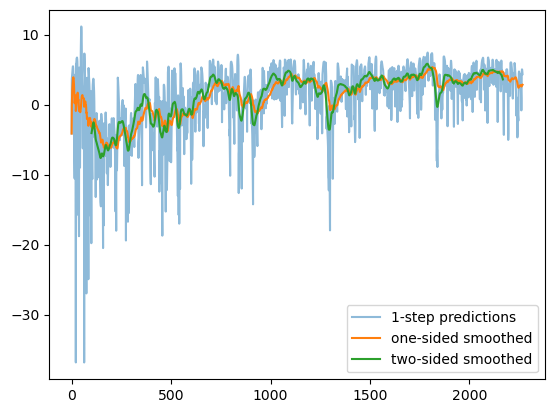

In [34]:
if not all_inline:
    %matplotlib qt


data = old_way_br.pred_list[:,0]
smoothed_data1 = one_sided_ewma(data,40)

plt.plot(data, alpha=.5)
plt.plot(smoothed_data1);

half_width = 100
smoothed_data2 = two_sided_ewma(data,half_width)
plt.plot(np.arange(smoothed_data2.size) + half_width, smoothed_data2);

plt.legend(["1-step predictions", "one-sided smoothed", "two-sided smoothed"]);

#### Smoothed Predictions and alpha

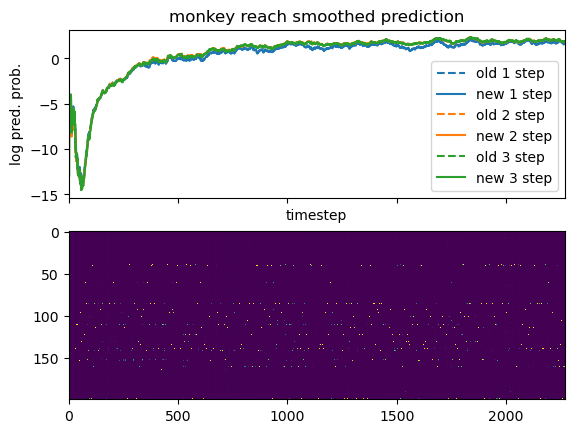

In [35]:
# shows smoothed predictions over time

if not all_inline:
    %matplotlib qt
    
show_states_instead_of_alpha = True

smoothing_scale = 40
br = shuffled_br

fig, axs = plt.subplots(2,1, sharex=True)
steps = [1,2,3]
for si, step in enumerate(steps):
    i = br.bw_parameters["lookahead_steps"].index(step)
    old_pred = br.pred_list[:,i]
    new_pred = br.pred_list[:,i]
    # plt.plot(pred)


    smoothed_old_pred = one_sided_ewma(old_pred, smoothing_scale)
    smoothed_new_pred = one_sided_ewma(new_pred, smoothing_scale)
    half_width = 0 # NOTE: set this if you use the two-sided ewma function
    
    axs[0].plot(np.arange(smoothed_old_pred.size) + half_width, smoothed_old_pred, color=f'C{si}', linestyle='dashed')
    x_correction = (step-1)*1
    axs[0].plot(np.arange(smoothed_new_pred.size) + half_width + x_correction,smoothed_new_pred, color=f'C{si}',linestyle='solid')

legend = []
for step in steps:
    legend.append(f"old {step} step")
    legend.append(f"new {step} step")
axs[0].legend(legend)
axs[0].set_title(f"{dataset} smoothed prediction")
axs[0].set_xlabel("timestep")
axs[0].set_ylabel("log pred. prob.");



if states is not None and show_states_instead_of_alpha:
    axs[1].plot(states,'.')
else:
    alpha = br.alpha_list.T
    state_means = alpha.mean(axis=1)
    # alpha = alpha[state_means > np.quantile(state_means, .75),:]
    alpha = alpha[np.argsort(-alpha.mean(axis=1)) - (alpha.shape[0]//2),:]
    axs[1].imshow((alpha), aspect="auto", interpolation="nearest")
# axs[0].set_xlim([500, 1000])

#### Smoothed predictions and entropy

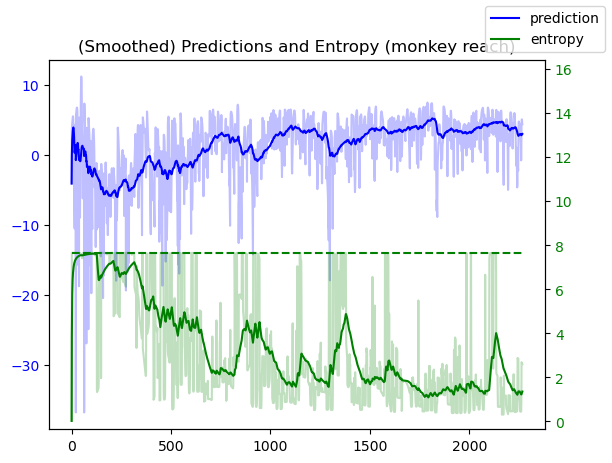

In [36]:
# shows smoothed predictions and entropy
if not all_inline:
    %matplotlib qt

    
br = new_way_br

smooting_scale = 50

predictions = br.pred_list[:,0]
smoothed_predictions = one_sided_ewma(predictions,smooting_scale)

fig, ax1 = plt.subplots()
ax1.plot(predictions, alpha=0.25, color='blue')
ax1.plot(smoothed_predictions, color='blue', label = "prediction")
ax1.tick_params(axis='y',labelcolor='blue')
ax1.set_title(f"(Smoothed) Predictions and Entropy ({dataset})")


entropy = br.entropy_list[:,0]
smoothed_entropy = one_sided_ewma(entropy, smooting_scale)
ax2 = ax1.twinx()
ax2.plot(entropy, color='green', alpha=0.25)
ax2.plot(smoothed_entropy, color='green', label="entropy")
max_entropy = np.log2(br.bw_parameters["num"])
ax2.plot([0, entropy.shape[0]], [max_entropy,]*2, 'g--')
ax2.tick_params(axis='y',labelcolor='green')
ymin, ymax = ax2.get_ylim()
ax2.set_ylim((ymin, 2*(ymax-ymin) + ymin))

fig.legend()

# Alpha analysis

In [641]:
plt.plot(br.alpha_list[:,br.dead_nodes].sum(axis=1))

# Exponentially weighted least squares

### Artificial Regression Problem

In [449]:
rng = np.random.default_rng()

In [577]:
d = 2
n = 100

w_true = np.array([-1,1]).reshape(-1,1)

C = np.zeros(shape=(0,d))
for i in range(n):
    alpha = rng.multivariate_normal([1,1],[[1,0],[0,1]]).reshape(-1,1)
    C = np.vstack((C,alpha.T))
    
y= rng.multivariate_normal(np.squeeze(C @ w_true), np.diag([.9**x for x in range(n)]))

### Real regression Problem

In [644]:
C = br.alpha_list
# mask =  np.full(C.shape[1], True)
# mask[br.dead_nodes] = False
# C = C[:,mask]

y = np.tile(obs,C.shape[0]//obs.shape[0])
y.shape

(145152,)

### Vanilla

In [660]:
w = 30
D = np.linalg.inv(C[:w,:].T @ C[:w,:])
Ct_y = C[:w,:].T @ y[:w]

for i in range(w,n):
    alpha = C[i,:,None]
    D = D - D @ alpha @ alpha.T  @ D/(1 + alpha.T @ D @ alpha)
    Ct_y = Ct_y + y[i] * alpha.T
    

In [704]:
%matplotlib qt
fig, axs = plt.subplots(nrows=2,ncols=1)
axs[0].plot(D@Ct_y.T, label="vanilla")
axs[0].plot(wD@wCt_y.T, label="weighted")

axs[1].plot(np.linalg.inv(C.T @ C)@C.T@y, label="vanilla")
axs[1].plot(np.linalg.inv(C.T @ C + np.eye(C.shape[1]))@C.T@y, label="normalized")

axs[1].plot(np.linalg.inv(C.T @ (pre_V[:,None] * C)) @ (C.T * pre_V)  @ y, label="weighted")
axs[1].plot(np.linalg.inv(C.T @ (pre_V[:,None] * C) + np.eye(C.shape[1])) @ (C.T * pre_V)  @ y, label="weighted normalized")


axs[0].set_title("iterative")
axs[1].set_title("batch")

axs[0].legend()
axs[1].legend()

In [699]:
(C.T @  C).shape

(200, 200)

In [701]:
C.T * pre_V

array([[3.71356223e-006, 3.72473576e-003, 3.73594429e-003, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [3.71356223e-006, 3.72473576e-003, 3.73594429e-003, ...,
        1.38692874e+164, 3.38382145e+162, 1.43990938e+161],
       [3.71356223e-006, 3.72473576e-003, 3.73594429e-003, ...,
        1.83133980e+187, 3.11305241e+187, 3.47781801e+187],
       ...,
       [3.71356223e-006, 3.72473576e-003, 3.73594429e-003, ...,
        4.08468817e+172, 2.70098078e+171, 2.78387269e+170],
       [3.71356223e-006, 3.72473576e-003, 3.73594429e-003, ...,
        4.12821640e+172, 2.78316248e+171, 2.91564785e+170],
       [3.71356223e-006, 3.72473576e-003, 3.73594429e-003, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000]])

In [650]:
assert np.allclose(np.linalg.inv(C.T @ C), D)
assert np.allclose(C.T @ y, Ct_y)

AssertionError: 

In [634]:
y.shape

(145152,)

### Weighted version

In [692]:
v = .997

pre_V = np.array([v**(n-(i+1)) for i in range(C.shape[0])])
# V = np.diag(pre_V)


In [669]:
w = 30

sub_V = np.diag([v**(w-(i+1)) for i in range(w)])
wD = np.linalg.inv(C[:w,:].T @ sub_V @ C[:w,:])
wCt_y = C[:w,:].T@ sub_V @ y[:w]

for i in range(w,n):
    alpha = C[i,:,None]
    wD = wD/v
    wD = wD - wD @ alpha @ alpha.T  @ wD/(1 + alpha.T @ wD @ alpha)
    wCt_y = v*wCt_y + y[i] * alpha.T
    

In [512]:
assert np.allclose(np.linalg.inv(C.T @ V @ C), D)
assert np.allclose(C.T @ V @ y, Ct_y)

In [518]:
((np.linalg.inv(C.T @ C) @ C.T @ y - w_true.T)**2).sum() / ((np.linalg.inv(C.T @ V @ C) @ C.T @ V @ y - w_true.T)**2).sum()

275.36330393074485

In [694]:
np.array(pre_V).shape

(145152,)